# MDA: Entrenamiento

El objetivo de este proyecto es la detección de asentamientos utilizando diferentes modelos de machine learning. 

Se exploraron dos tipos de imágenes, por un lado las generadas con el vuelo aéreo y por otro las provenientes del satélite Sentinel 2. A su vez, para cada uno de los casos se exploraron diferentes alternativas de información en las imágenes

* Imagen RGB
* Imagen RGB + capa de parcelas DINOT
* Imágenes RGB + capa de parcelas DINOT + Densidad demográfica Mayores 60 años (Facebook)

Esta información se añade en forma de una  banda extra en la imagen, de este modo pasan a ser de 3 bandas (RGB) a 4 o 5 bandas. 

### Descarga de las imágenes  (vuelo)

In [ ]:
!pip install ideuy

In [ ]:
!ogr2ogr data/shp/simplified_aoi_5381.geojson \
         data/shp/simplified_aoi.geojson  \
         -f GeoJSON  \
         -t_srs epsg:5381 

In [ ]:
!ideuy_filter --type national \
              --output data/shp/grilla_nacional_filtrada_train.geojson \
              data/shp/simplified_aoi_5381.geojson

In [ ]:
!ideuy_download --type national \
                --product-type rgb_8bit \
                --output-dir data/tmp/images_train/ \
                 data/shp/grilla_nacional_filtrada_train.geojson

## Preprocesamiento: Vuelo


### Imágenes 3D

![](img/vuelo_r1.png)

La generacion de las imágenes y máscaras se realiza vía *meduy_extract_chips*. Esta herramienta se utiliza tanto en la generación del dataset de entrenamiento como en el de predicción, en el primer caso se generan las imágenes y las máscaras y en el segundo solo las imágenes.

Para generar las imágenes 3D del entrenamiento:

In [ ]:
!meduy_extract_chips \
    data/tmp/images_train/*.jpg \
    -o data/data_train_3D/vuelo/600_600/ \
    --size 600 \
    --step-size 600 \
    --crs epsg:5382 \
    --aoi data/shp/asentamientos_mvd_2018.geojson

###### Donde los argumentos son:

* **El primer argumento** es la ruta a las imágenes 

* **o** es la ruta de destino 

Recomendamos que dicha ruta sea descriptiva, por ejemplo “data_train/600_600/Remesa08/ ” describe : Data_train → datos usados para entrenar; 400_400 → <tamaño de la imagen >_ <tamaño del step-size> (las imágenes son cuadradas); Remesa08 → Remesa sobre la que vamos a trabajar

* **size** tamaño de las imágenes resultantes (las imágenes son cuadradas) 
* **step-size** paso del proceso. Si *step-size* es igual que el *size* entonces no hay overlap en las imágenes. 

En ocaciones es útil para el entrenamiento generar los chips con un overlap de este modo tenemos más datos para entrenar. Pero en la predicción valor debe ser igual al tamaño que la imagen 

* **crs** epsg:5382 le asigna un epsg a la imagen 

* **label-property** nombre del campo donde se define cada categoría (solo se usa para el entrenamiento) 

* **classes** nombres de las clases (como aparecen en el geojson), separados por espacios

* **aoi** ruta al archivo vectorial donde están definidas las localidades. Al definir una region de interés solo se procesan las imágenes que interceptan esas localidades.

Este comando va a generar dos carpetas en la ruta de destino : “images” y “masks”. Los archivos de la primera van a ser de tipo Tiff de 3 bandas (rgb) y los de la segunda van a ser, también, de tipo Tiff pero de N bandas donde N representa el número de clases, en este caso 4. Y donde cada una de las bandas es una máscara binaria


In [15]:
!tree data -d

/home/ro/meduy-mda/data
├── 4D_S2
├── 4D_vuelo
│   └── parcelas_remesas
├── 5D_vuelo
├── data_predict
│   ├── S2
│   │   ├── 3D
│   │   │   └── 160_160
│   │   │       └── images
│   │   ├── 4D
│   │   │   └── 160_160
│   │   │       └── images
│   │   └── 5D
│   └── vuelo
│       ├── 3D
│       │   └── Remesa09
│       │       └── images
│       ├── 4D
│       │   └── 600_600
│       │       ├── Remesa01
│       │       │   └── images
│       │       ├── Remesa02
│       │       │   └── images
│       │       ├── Remesa03
│       │       │   └── images
│       │       ├── Remesa04
│       │       │   └── images
│       │       ├── Remesa05
│       │       │   └── images
│       │       ├── Remesa06
│       │       │   └── images
│       │       ├── Remesa07
│       │       │   └── images
│       │       ├── Remesa08
│       │       │   └── images
│       │       ├── Remesa09
│       │       │   └── images
│       │       ├── Remesa10
│       │       │   └── images
│       │       ├── 

### Imágenes 4D

![](img/4D.png)

Como mencionamos anteriormente, tambien es necesario generar los datos de entrenamiento con las imagenes 4D (y 5D) ya que cada modelo es independiente. 

In [ ]:
from meduy.postprocess.concatenate import concatenate

input_dir  = 'data/data_train_3D/vuelo/600_600/images/'
output_dir = 'data/data_train_4D/vuelo/600_600/images/'
band_path  = 'data/4D_vuelo/parcelas_remesas/parcelas_remesa_1.tif'  ###

concatenate(input_dir=input_dir,output_dir= output_dir, band_path=band_path)

input_dir  = 'data/data_train_3D/vuelo/600_600/images/'
output_dir = 'data/data_train_4D/vuelo/600_600/images/'
band_path  = 'data/4D_vuelo/parcelas_remesas/parcelas_remesa_6.tif'  ###

concatenate(input_dir=input_dir, output_dir=output_dir,band_path= band_path)


Además debemos copiar las máscaras.

In [ ]:
!os.makedirs('data/data_train_4D/vuelo/600_600/masks/', exist_ok=True)
!cp /home/ro/meduy-mda/data/data_train_3D/vuelo/600_600/masks/* /home/ro/meduy-mda/data/data_train_4D/vuelo/600_600/masks/ 

### Imágenes 5D

![](img/5D.png)

De igual modo generamos las imágenes 5D a partir de las 4D.

In [ ]:
from meduy.postprocess.concatenate import concatenate

input_dir  = 'data/data_train_4D/vuelo/600_600/images/'
output_dir = 'data/data_train_5D/vuelo/600_600/images/'
band_path  = 'data/5D_vuelo/capa_5D.tif'  ###

concatenate(input_dir=input_dir,output_dir= output_dir, band_path=band_path)

Y copiamos las máscaras.

In [ ]:
#!os.makedirs('data/data_train_5D/vuelo/600_600/masks/', exist_ok=True)
!cp -r data/data_train_4D/vuelo/600_600/masks data/data_train_5D/vuelo/600_600/ 

In [ ]:
!tree data/ -d

## Entrenamiento - Vuelo 

### Entrenamiento 3D

Las librerías que importamos nos permite acceder a las herramientas que vamos a utilizar a lo largo del proyecto como por ejemplo la función de train y predict  del modelo de Unet.

In [6]:
from meduy.unet.train import TrainConfig, train
from meduy.unet.evaluate import plot_data_generator
import os

/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-pack

En esta etapa debemos definir la configuración del modelo de ML


In [19]:
config_3D = TrainConfig(width=320,  #  tamaño de la imagen procesada por la UNet (debe ser multiplos de 16 , por ej 160, 320,etc)
                     height=320,
                     n_channels=3,  #  número de canales de la imagen, rgb -> 3
                     n_classes=1, # número de clases a clasificar
                     apply_image_augmentation=True, #  si es True , amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes 
                     seed=42,
                     epochs=15, # Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento
                     batch_size=32, #cantidad de datos que se procesan por vez, puede ser limitado por la memoria de gpu disponible (debe ser multiplo de 16)
                     steps_per_epoch=200, #  típicamente debe ser igual al numero de imágenes / el batch_size, si es mayor incrementara el número de imágenes generadas con image augmentation
                     early_stopping_patience=3, # a medida que entrena se guarda los resultados del entrenamiento despues de cada epoch, si el error no varió luego de 3 iteraciones , se corta el proceso porque se entiende que el error ya disminuyó significativamente 
                     validation_split=0.2, # se divide la muestra en training y validation para calcular el error durante el proceso de entrenamiento
                     images_path=os.path.join('./data/data_train','vuelo','3D', '600_600'), #ruta a las imágenes
                     model_path=os.path.join('./weights/', 'UNet_asentamientos_3D_600-600_spe200.h5')) #  ruta al archivo de entrenamiento

Podemos visualizar alguna de las imágenes y máscaras.

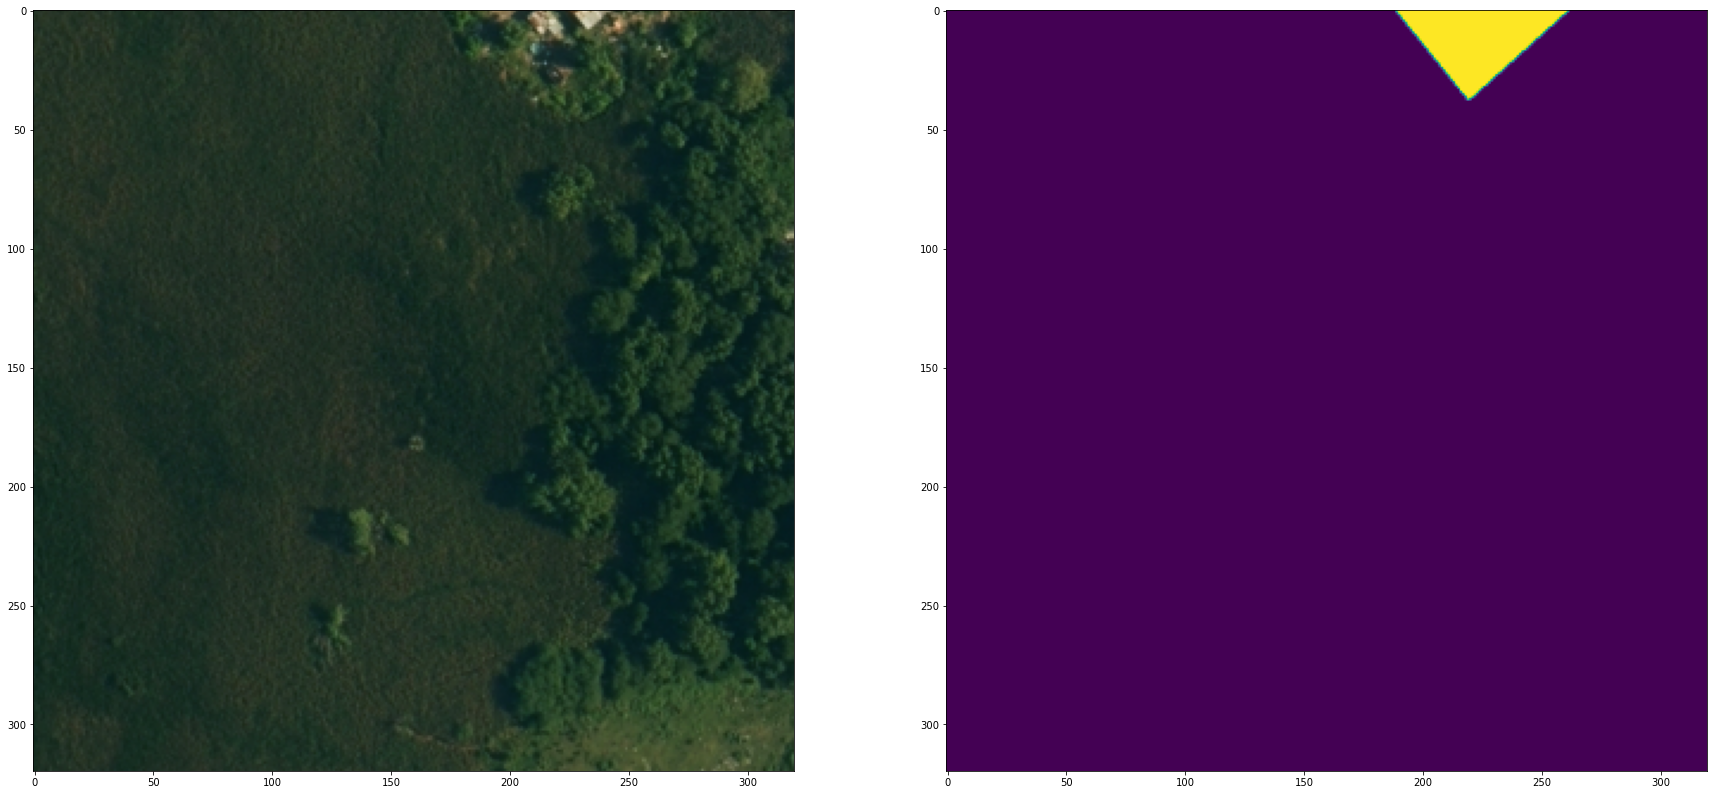

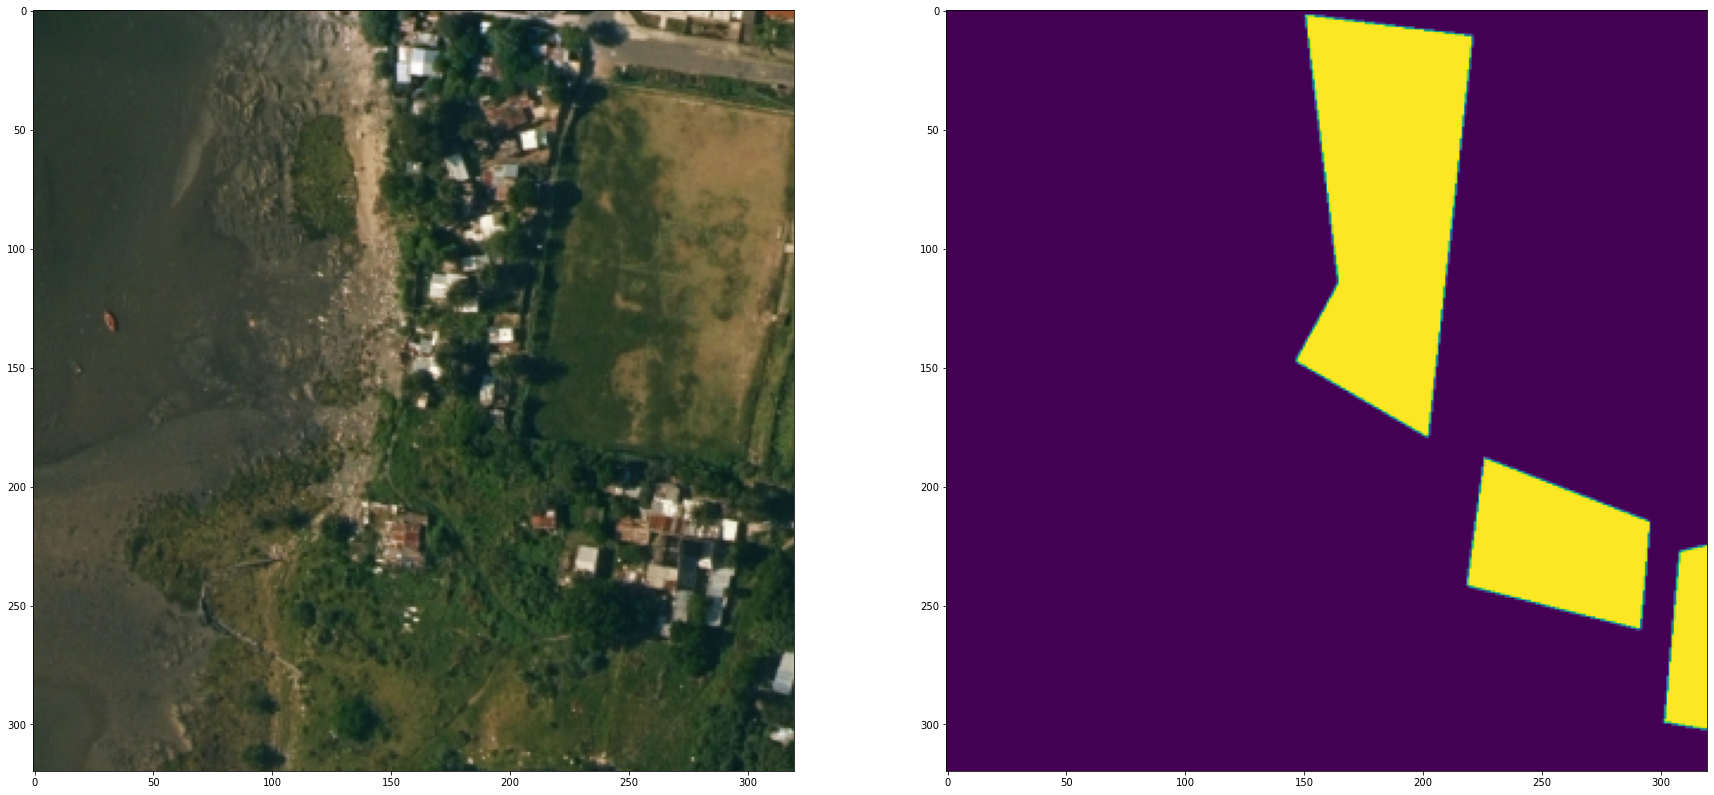

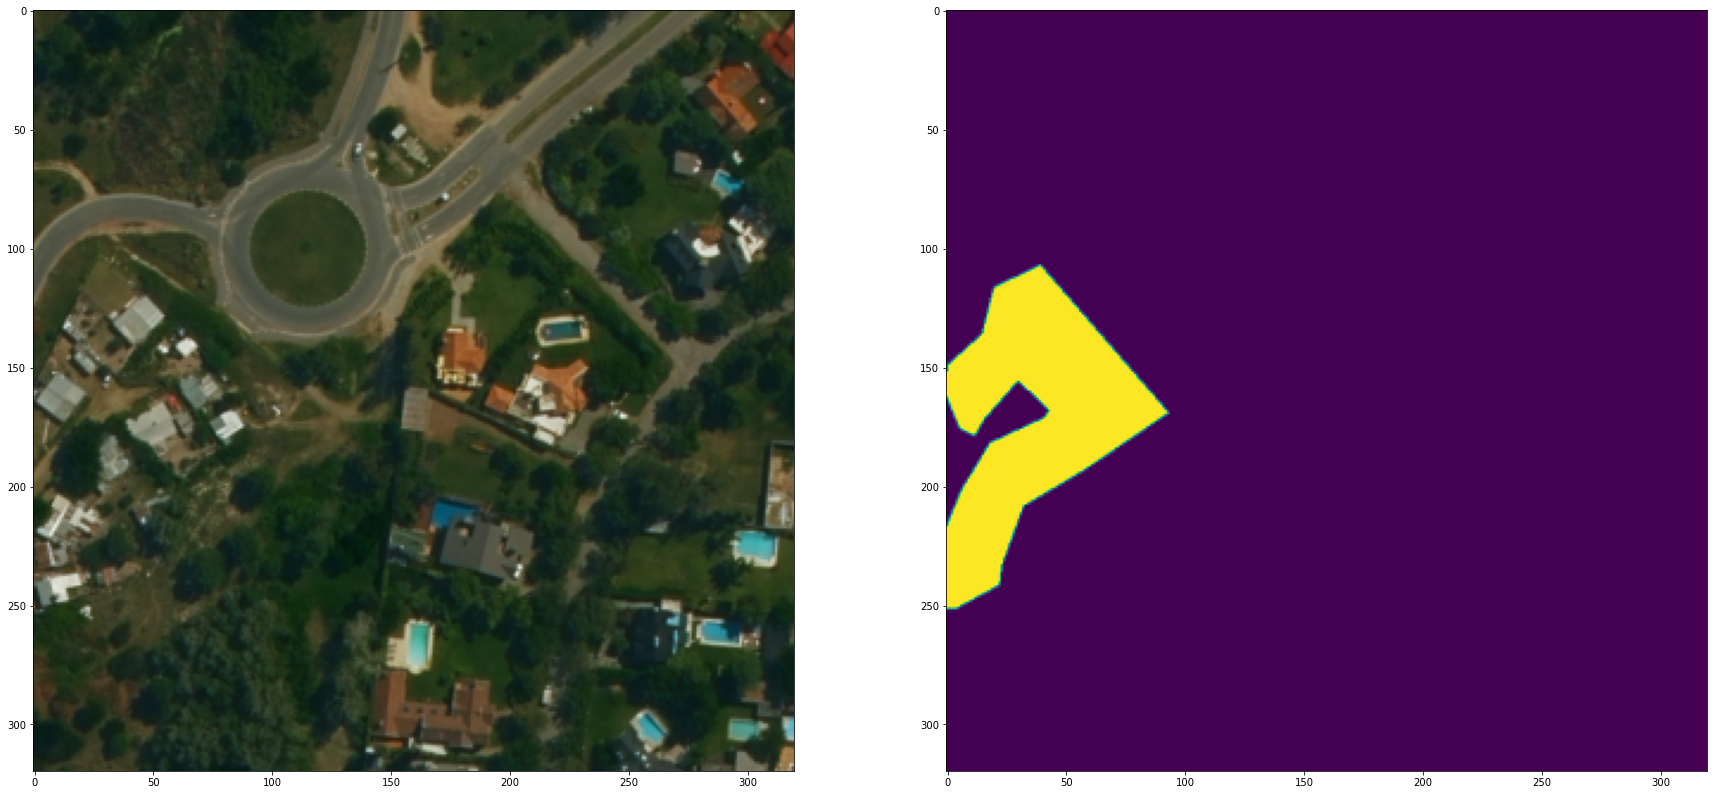

In [8]:
plot_data_generator(train_config=config_3D, num_samples=3, fig_size=(30,20))

Ejecuta el entrenamiento.

In [20]:
res_config_3D = train(config_3D)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_162 (Conv2D)             (None, 320, 320, 32) 896         input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, 320, 320, 32) 9248        conv2d_162[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_36 (MaxPooling2D) (None, 160, 160, 32) 0           conv2d_163[0][0]                 
____________________________________________________________________________________________

### Entrenamiento - 4D

In [1]:
from meduy.unet.train import TrainConfig, train
from meduy.unet.evaluate import plot_data_generator
import os

/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-pack

In [6]:
config_4D = TrainConfig(width=320,  #  tamaño de la imagen procesada por la UNet (debe ser multiplos de 16 , por ej 160, 320,etc)
                     height=320,
                     n_channels=4, ### #  número de canales de la imagen, rgb -> 3
                     n_classes=1, # número de clases a clasificar
                     apply_image_augmentation=True, #  si es True , amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes 
                     seed=42,
                     epochs=15, # Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento
                     batch_size=32, #cantidad de datos que se procesan por vez, puede ser limitado por la memoria de gpu disponible (debe ser multiplo de 16)
                     steps_per_epoch=200, #  típicamente debe ser igual al numero de imágenes / el batch_size, si es mayor incrementara el número de imágenes generadas con image augmentation
                     early_stopping_patience=3, # a medida que entrena se guarda los resultados del entrenamiento despues de cada epoch, si el error no varió luego de 3 iteraciones , se corta el proceso porque se entiende que el error ya disminuyó significativamente 
                     validation_split=0.2, # se divide la muestra en training y validation para calcular el error durante el proceso de entrenamiento
                     images_path=os.path.join('./data/data_train/','vuelo','4D', '600_600'),### #ruta a las imágenes
                     model_path=os.path.join('./weights/', 'UNet_asentamientos_4D_600-600_spe200.h5')) #  ruta al archivo de entrenamiento

In [7]:
res_4D_vuelo = train(config_4D)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 320, 320, 4)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 320, 320, 32) 1184        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 320, 320, 32) 9248        conv2d_47[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 160, 160, 32) 0           conv2d_48[0][0]                  
____________________________________________________________________________________________

RuntimeError: Your generator is NOT thread-safe.Keras requires a thread-safe generator when`use_multiprocessing=False, workers > 1`.For more information see issue #1638.

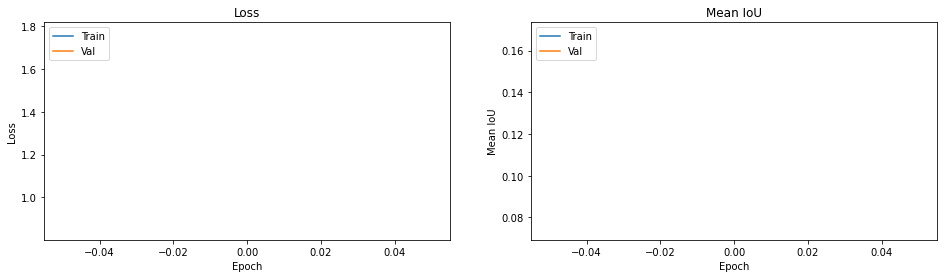

In [8]:
 import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(res_4D_vuelo.history['loss'])
plt.plot(res_4D_vuelo.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(res_4D_vuelo.history['mean_iou'])
plt.plot(res_4D_vuelo.history['val_mean_iou'])
plt.title('Mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

### Entrenamiento -  5D

In [1]:
from meduy.unet.train import TrainConfig, train
from meduy.unet.evaluate import plot_data_generator
import os

/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ro/miniconda3/envs/tf-gpu/lib/python3.7/site-pack

In [2]:

config_5D = TrainConfig(width=320,  #  tamaño de la imagen procesada por la UNet (debe ser multiplos de 16 , por ej 160, 320,etc)
                     height=320,
                     n_channels=5, ### #  número de canales de la imagen, rgb -> 3
                     n_classes=1, # número de clases a clasificar
                     apply_image_augmentation=True, #  si es True , amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes 
                     seed=42,
                     epochs=15, # Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento
                     batch_size=32, #cantidad de datos que se procesan por vez, puede ser limitado por la memoria de gpu disponible (debe ser multiplo de 16)
                     steps_per_epoch=200, #  típicamente debe ser igual al numero de imágenes / el batch_size, si es mayor incrementara el número de imágenes generadas con image augmentation
                     early_stopping_patience=3, # a medida que entrena se guarda los resultados del entrenamiento despues de cada epoch, si el error no varió luego de 3 iteraciones , se corta el proceso porque se entiende que el error ya disminuyó significativamente 
                     validation_split=0.2, # se divide la muestra en training y validation para calcular el error durante el proceso de entrenamiento

                     images_path=os.path.join('./data/data_train/','vuelo','5D', '600_600'),### #ruta a las imágenes
                     model_path=os.path.join('./weights/', 'UNet_asentamientos_5D_600-600_spe200.h5')) #  ruta al archivo de entrenamiento


In [3]:
res_5D_vuelo = train(config_5D)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 5)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 32) 1472        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 320, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 160, 160, 32) 0           conv2d_2[0][0]                 







## Preprocesamiento: Sentinel 2

### Imágenes 3D

![](img/s2.png)

Generamos las imágenes y máscaras para el entrenamiento.

In [ ]:
!meduy_extract_chips data/tmp/S2/*.tif \
                     -o data/data_train_3D/S2/160_60/ \
                     --size 160 \
                     --step-size 60 \
                     --crs epsg:5382 \
                     --aoi data/shp/asentamientos_mvd_2018.geojson

### Imágenes 4D

![](img/s2_4D.png)

In [ ]:
from meduy.postprocess import concatenate

input_dir  = 'data/data_train_3D_S2/160_60/images/*.tif'
output_dir = 'data_train_4D_S2/160_60/images/'
band_path  = 'data/4D_S2/capa_4D_.tif'

concatenate(input_dir, output_dir, band_path)

input_dir  = 'data/data_train_3D_S2/160_60/images/*.tif'
output_dir = 'data/data_train_4D_S2/160_60/images/'
band_path  = 'data/4D_S2/capa_4D_.tif'

concatenate(input_dir, output_dir, band_path)

In [ ]:
!os.makedirs('data/data_train_4D_S2/160_60/masks/', exist_ok=True)
!cp data/data_train_4D_S2/160_60/masks/* data/data_train_5D/vuelo/600_600/masks/ 

### Imágenes 5D

![](img/s25d.png)

In [ ]:
from meduy.postprocess import concatenate

input_dir  = 'data/data_train_4D/vuelo/600_600/images/*.tif'
output_dir = 'data/data_train_5D/vuelo/600_600/images/'
band_path  = 'data/5D_vuelo/capa_5D.tif'

concatenate(input_dir, output_dir, band_path)

In [ ]:
!os.makedirs('data/data_train_5D/vuelo/600_600/masks/', exist_ok=True)
!cp data/data_train_4D/vuelo/600_600/masks/* data/data_train_5D/vuelo/600_600/masks/ 

## Entrenamiento - Sentinel 2

### Imágenes 3D

In [4]:
from meduy.unet.train import TrainConfig, train
from meduy.unet.evaluate import plot_data_generator
import os

In [12]:
config_3D_S2 = TrainConfig(width=160,  #  tamaño de la imagen procesada por la UNet (debe ser multiplos de 16 , por ej 160, 320,etc)
                     height=160,
                     n_channels=3, ### #  número de canales de la imagen, rgb -> 3
                     n_classes=1, # número de clases a clasificar
                     apply_image_augmentation=True, #  si es True , amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes 
                     seed=42,
                     epochs=15, # Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento
                     batch_size=32, #cantidad de datos que se procesan por vez, puede ser limitado por la memoria de gpu disponible (debe ser multiplo de 16)
                     steps_per_epoch=500, #  típicamente debe ser igual al numero de imágenes / el batch_size, si es mayor incrementara el número de imágenes generadas con image augmentation
                     early_stopping_patience=3, # a medida que entrena se guarda los resultados del entrenamiento despues de cada epoch, si el error no varió luego de 3 iteraciones , se corta el proceso porque se entiende que el error ya disminuyó significativamente 
                     validation_split=0.2, # se divide la muestra en training y validation para calcular el error durante el proceso de entrenamiento
                     images_path=os.path.join('./data/data_train','S2','3D', '160_60'),### #ruta a las imágenes
                     model_path=os.path.join('./weights/', 'UNet_asentamientos_S2_3D_160_60_spe500.h5')) #  ruta al archivo de entrenamiento

In [13]:
res_config_3D_S2 = train(config_3D_S2)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 160, 160, 32) 896         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 160, 160, 32) 9248        conv2d_93[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 80, 80, 32)   0           conv2d_94[0][0]                  
____________________________________________________________________________________________

### Imágenes 4D

In [ ]:
from meduy.unet.train import TrainConfig, train
from meduy.unet.evaluate import plot_data_generator
import os

In [15]:
config_4D_S2 = TrainConfig(width=160,  #  tamaño de la imagen procesada por la UNet (debe ser multiplos de 16 , por ej 160, 320,etc)
                     height=160,
                     n_channels=4, ### #  número de canales de la imagen, rgb -> 3
                     n_classes=1, # número de clases a clasificar
                     apply_image_augmentation=True, #  si es True , amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes 
                     seed=42,
                     epochs=15, # Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento
                     batch_size=32, #cantidad de datos que se procesan por vez, puede ser limitado por la memoria de gpu disponible (debe ser multiplo de 16)
                     steps_per_epoch=500, #  típicamente debe ser igual al numero de imágenes / el batch_size, si es mayor incrementara el número de imágenes generadas con image augmentation
                     early_stopping_patience=3, # a medida que entrena se guarda los resultados del entrenamiento despues de cada epoch, si el error no varió luego de 3 iteraciones , se corta el proceso porque se entiende que el error ya disminuyó significativamente 
                     validation_split=0.2, # se divide la muestra en training y validation para calcular el error durante el proceso de entrenamiento
                     images_path=os.path.join('./data/data_train/','S2','4D', '160_60'),### #ruta a las imágenes
                     model_path=os.path.join('./weights/', 'UNet_asentamientos_S2_4D_160_60_spe500.h5')) #  ruta al archivo de entrenamiento

In [16]:
res_config_4D_S2 = train(config_4D_S2)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 160, 160, 4)  0                                            
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 160, 160, 32) 1184        input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_117 (Conv2D)             (None, 160, 160, 32) 9248        conv2d_116[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_26 (MaxPooling2D) (None, 80, 80, 32)   0           conv2d_117[0][0]                 
____________________________________________________________________________________________

### Imágenes 5D

In [ ]:
from meduy.unet.train import TrainConfig, train
from meduy.unet.evaluate import plot_data_generator
import os

In [17]:
config_5D_S2 = TrainConfig(width=160,  #  tamaño de la imagen procesada por la UNet (debe ser multiplos de 16 , por ej 160, 320,etc)
                     height=160,
                     n_channels=5, ### #  número de canales de la imagen, rgb -> 3
                     n_classes=1, # número de clases a clasificar
                     apply_image_augmentation=True, #  si es True , amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes 
                     seed=42,
                     epochs=15, # Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento
                     batch_size=32, #cantidad de datos que se procesan por vez, puede ser limitado por la memoria de gpu disponible (debe ser multiplo de 16)
                     steps_per_epoch=500, #  típicamente debe ser igual al numero de imágenes / el batch_size, si es mayor incrementara el número de imágenes generadas con image augmentation
                     early_stopping_patience=3, # a medida que entrena se guarda los resultados del entrenamiento despues de cada epoch, si el error no varió luego de 3 iteraciones , se corta el proceso porque se entiende que el error ya disminuyó significativamente 
                     validation_split=0.2, # se divide la muestra en training y validation para calcular el error durante el proceso de entrenamiento
                     images_path=os.path.join('./data/data_train','S2','5D', '160_60'),### #ruta a las imágenes
                     model_path=os.path.join('./weights/', 'UNet_asentamientos_S2_5D_160_60_spe500.h5')) #  ruta al archivo de entrenamiento

In [18]:
res_config_5D_S2 = train(config_5D_S2)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 160, 160, 5)  0                                            
__________________________________________________________________________________________________
conv2d_139 (Conv2D)             (None, 160, 160, 32) 1472        input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, 160, 160, 32) 9248        conv2d_139[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_31 (MaxPooling2D) (None, 80, 80, 32)   0           conv2d_140[0][0]                 
____________________________________________________________________________________________